In [22]:
# Cell 1: Imports
import os, sys, math, time, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import umap
import shap

In [23]:
# Cell 2: Configuration
DATA_DIR = "/kaggle/input/animal-images/dataset"
FEATURE_DIR = "features"
MODELS_DIR = "models"

IMG_SIZE = 224
BATCH_SIZE = 16           
RANDOM_SEED = 42

PCA_COMPONENTS = 256
AE_LATENT = 256
AE_EPOCHS = 40            
AE_BATCH = 32
UMAP_COMPONENTS = 256
CV_FOLDS = 5

DO_PCA = True
DO_AUTOENC = True
DO_UMAP = True

os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [24]:
# Cell 3: Load dataset, transform, and split (train/val/test)
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.15,0.15,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Using ImageFolder to read dataset structure
assert os.path.exists(DATA_DIR), f"Dataset path not found: {DATA_DIR}"
full_dataset = ImageFolder(DATA_DIR, transform=transform_train)  # transform overridden for val/test later

classes = full_dataset.classes
N = len(full_dataset)
train_n = int(0.7 * N)
val_n = int(0.15 * N)
test_n = N - train_n - val_n
train_ds, val_ds, test_ds = random_split(full_dataset, [train_n, val_n, test_n],
                                         generator=torch.Generator().manual_seed(RANDOM_SEED))

# override transforms for val/test
# Note: random_split returns Subset with original dataset; we update transforms directly on dataset sample by sample
# Easier approach: make wrappers
from torch.utils.data import Subset

class WrappedImageFolder(ImageFolder):
    pass

# Recreate datasets using explicit file lists so transforms differ
all_paths = np.array([p for p, _ in full_dataset.samples])
all_targets = np.array([t for _, t in full_dataset.samples])
# get indices for the splits used above
train_idx = list(train_ds.indices)
val_idx = list(val_ds.indices)
test_idx = list(test_ds.indices)

def make_subset(paths_idx, transform):
    subset_paths = [full_dataset.samples[i][0] for i in paths_idx]
    subset_targets = [full_dataset.samples[i][1] for i in paths_idx]
    # create temporary ImageFolder-like dataset from lists
    class SimpleListDataset(torch.utils.data.Dataset):
        def __init__(self, paths, targets, transform):
            self.paths = paths
            self.targets = targets
            self.transform = transform
        def __len__(self):
            return len(self.paths)
        def __getitem__(self, i):
            img = transforms.functional.pil_to_tensor(transforms.functional.pil_image_loader(self.paths[i])) if False else None
            # above line won't run; instead use PIL open
            from PIL import Image
            img = Image.open(self.paths[i]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, self.targets[i]
    return SimpleListDataset(subset_paths, subset_targets, transform)

train_dataset = make_subset(train_idx, transform_train)
val_dataset = make_subset(val_idx, transform_val)
test_dataset = make_subset(test_idx, transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", classes)
print(f"Sizes -> Train: {len(train_dataset)} Val: {len(val_dataset)} Test: {len(test_dataset)}  (Total: {N})")

Classes: ['cat', 'cow', 'dog', 'lamb', 'zebra']
Sizes -> Train: 372 Val: 79 Test: 81  (Total: 532)


In [25]:
# Cell 4: Load pretrained backbones (EfficientNet-B0, ResNet50, ViT-B16) and build feature extractors
def load_effb0(device):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    feat = nn.Sequential(*(list(model.children())[:-1])).to(device).eval()  # outputs (batch, 1280, 1,1)
    return feat

def load_resnet50(device):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    feat = nn.Sequential(*(list(model.children())[:-1])).to(device).eval()  # outputs (batch, 2048,1,1)
    return feat

def load_vit_b16(device):
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
    model.heads = nn.Identity()  # now outputs pre-logits (batch, hidden_dim)
    model.to(device).eval()
    return model

print("Loading backbones (this may download weights on first run)...")
eff = load_effb0(DEVICE)
res = load_resnet50(DEVICE)
vit = load_vit_b16(DEVICE)
print("Backbones ready.")

Loading backbones (this may download weights on first run)...
Backbones ready.


In [26]:
# Cell 5: Extract & save features for train/val/test (concatenate eff+res+vit per image)
def extract(loader, eff_model, res_model, vit_model, device):
    feats_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs = imgs.to(device)
            e = eff_model(imgs)                # (b,1280,1,1)
            e = e.view(e.size(0), -1)          # (b,1280)
            r = res_model(imgs)                # (b,2048,1,1)
            r = r.view(r.size(0), -1)          # (b,2048)
            v = vit_model(imgs)                # (b,vit_dim)
            if v.ndim == 1:
                v = v.unsqueeze(0)
            v = v.view(v.size(0), -1)
            cat = torch.cat([e, r, v], dim=1)  # (b, sum_dims)
            feats_list.append(cat.cpu().numpy())
            labels_list.append(lbls.numpy())
    X = np.concatenate(feats_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

print("Extracting features (train)...")
X_train, y_train = extract(train_loader, eff, res, vit, DEVICE)
print("Extracting features (val)...")
X_val, y_val = extract(val_loader, eff, res, vit, DEVICE)
print("Extracting features (test)...")
X_test, y_test = extract(test_loader, eff, res, vit, DEVICE)

print("Feature shapes:", X_train.shape, X_val.shape, X_test.shape)
np.savez_compressed(os.path.join(FEATURE_DIR, "features.npz"),
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test,
                    classes=np.array(classes))
print("Saved features ->", os.path.join(FEATURE_DIR, "features.npz"))

Extracting features (train)...


100%|██████████| 24/24 [02:59<00:00,  7.48s/it]


Extracting features (val)...


100%|██████████| 5/5 [00:38<00:00,  7.77s/it]


Extracting features (test)...


100%|██████████| 6/6 [00:38<00:00,  6.48s/it]


Feature shapes: (372, 4096) (79, 4096) (81, 4096)
Saved features -> features/features.npz


In [27]:
# Cell 6: Load features and scale (StandardScaler)
data = np.load(os.path.join(FEATURE_DIR, "features.npz"))
X_train = data["X_train"]; y_train = data["y_train"]
X_val = data["X_val"]; y_val = data["y_val"]
X_test = data["X_test"]; y_test = data["y_test"]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(FEATURE_DIR, "scaler.pkl"))
print("Scaled shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Scaled shapes: (372, 4096) (79, 4096) (81, 4096)


In [28]:
# Cell 7: PCA reduction and save
if DO_PCA:
    pca = PCA(n_components=min(PCA_COMPONENTS, X_train_s.shape[1]), random_state=RANDOM_SEED)
    X_train_pca = pca.fit_transform(X_train_s)
    X_val_pca = pca.transform(X_val_s)
    X_test_pca = pca.transform(X_test_s)
    joblib.dump(pca, os.path.join(FEATURE_DIR, "pca.pkl"))
    np.savez_compressed(os.path.join(FEATURE_DIR, "reduced_pca.npz"),
                        X_train=X_train_pca, y_train=y_train,
                        X_val=X_val_pca, y_val=y_val,
                        X_test=X_test_pca, y_test=y_test)
    print("PCA done:", X_train_pca.shape)
else:
    print("PCA skipped.")

PCA done: (372, 256)


In [29]:
# Cell 8: Autoencoder reduction (train AE and save)
if DO_AUTOENC:
    class AE(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, input_dim)
            )
        def forward(self, x):
            z = self.encoder(x)
            out = self.decoder(z)
            return out

    device_ae = DEVICE
    ae = AE(X_train_s.shape[1], AE_LATENT).to(device_ae)
    opt = optim.Adam(ae.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    X_tensor = torch.from_numpy(X_train_s.astype(np.float32))
    ds_ae = torch.utils.data.TensorDataset(X_tensor)
    loader_ae = torch.utils.data.DataLoader(ds_ae, batch_size=AE_BATCH, shuffle=True)

    print("Training Autoencoder...")
    for epoch in range(AE_EPOCHS):
        ae.train()
        total_loss = 0.0
        for (batch,) in loader_ae:
            batch = batch.to(device_ae)
            recon = ae(batch)
            loss = loss_fn(recon, batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.size(0)
        if (epoch+1) % 10 == 0 or epoch==0:
            print(f"Epoch {epoch+1}/{AE_EPOCHS} avg_loss: {total_loss/len(ds_ae):.6f}")
    ae.eval()
    with torch.no_grad():
        X_train_ae = ae.encoder(torch.from_numpy(X_train_s.astype(np.float32)).to(device_ae)).cpu().numpy()
        X_val_ae = ae.encoder(torch.from_numpy(X_val_s.astype(np.float32)).to(device_ae)).cpu().numpy()
        X_test_ae = ae.encoder(torch.from_numpy(X_test_s.astype(np.float32)).to(device_ae)).cpu().numpy()
    joblib.dump(ae.state_dict(), os.path.join(FEATURE_DIR, "autoencoder_state.pth"))
    np.savez_compressed(os.path.join(FEATURE_DIR, "reduced_autoenc.npz"),
                        X_train=X_train_ae, y_train=y_train,
                        X_val=X_val_ae, y_val=y_val,
                        X_test=X_test_ae, y_test=y_test)
    print("Autoencoder done:", X_train_ae.shape)
else:
    print("Autoencoder skipped.")

Training Autoencoder...
Epoch 1/40 avg_loss: 0.943226
Epoch 10/40 avg_loss: 0.651907
Epoch 20/40 avg_loss: 0.459010
Epoch 30/40 avg_loss: 0.276449
Epoch 40/40 avg_loss: 0.169085
Autoencoder done: (372, 256)


In [30]:
# Cell 9: UMAP reduction and save
if DO_UMAP:
    reducer = umap.UMAP(n_components=UMAP_COMPONENTS, random_state=RANDOM_SEED)
    combined = np.vstack([X_train_s, X_val_s])
    reduced_combined = reducer.fit_transform(combined)
    X_train_um = reduced_combined[:len(X_train_s)]
    X_val_um = reduced_combined[len(X_train_s):len(X_train_s)+len(X_val_s)]
    X_test_um = reducer.transform(X_test_s)
    joblib.dump(reducer, os.path.join(FEATURE_DIR, "umap.pkl"))
    np.savez_compressed(os.path.join(FEATURE_DIR, "reduced_umap.npz"),
                        X_train=X_train_um, y_train=y_train,
                        X_val=X_val_um, y_val=y_val,
                        X_test=X_test_um, y_test=y_test)
    print("UMAP done:", X_train_um.shape)
else:
    print("UMAP skipped.")

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


UMAP done: (372, 256)


In [31]:
# Cell 10: Evaluate reducers (PCA / AE / UMAP) using RF cross-validation and pick best
kf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
scores = {}
if DO_PCA:
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    sc = cross_val_score(rf, X_train_pca, y_train, cv=kf, scoring="accuracy", n_jobs=-1)
    scores['pca'] = sc.mean()
    print("PCA CV acc:", scores['pca'])
if DO_AUTOENC:
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    sc = cross_val_score(rf, X_train_ae, y_train, cv=kf, scoring="accuracy", n_jobs=-1)
    scores['autoenc'] = sc.mean()
    print("Autoenc CV acc:", scores['autoenc'])
if DO_UMAP:
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    sc = cross_val_score(rf, X_train_um, y_train, cv=kf, scoring="accuracy", n_jobs=-1)
    scores['umap'] = sc.mean()
    print("UMAP CV acc:", scores['umap'])

best = max(scores, key=scores.get)
print("Best reducer chosen:", best)
with open(os.path.join(FEATURE_DIR, "best_reducer.txt"), "w") as f:
    f.write(best)

PCA CV acc: 0.9731171171171171
Autoenc CV acc: 0.9730450450450452
UMAP CV acc: 0.9597117117117119
Best reducer chosen: pca


In [32]:
# Cell 11: Load the selected reduced features for classification
best = open(os.path.join(FEATURE_DIR, "best_reducer.txt")).read().strip()
print("Using reducer:", best)
reduced = np.load(os.path.join(FEATURE_DIR, f"reduced_{best}.npz"))
X_train_red = reduced["X_train"]; y_train_red = reduced["y_train"]
X_val_red = reduced["X_val"]; y_val_red = reduced["y_val"]
X_test_red = reduced["X_test"]; y_test_red = reduced["y_test"]
print("Reduced shapes:", X_train_red.shape, X_val_red.shape, X_test_red.shape)

Using reducer: pca
Reduced shapes: (372, 256) (79, 256) (81, 256)


Tuning KNN...
Best KNN params: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'} CV: 0.948972972972973
KNN Test acc: 0.9876543209876543
              precision    recall  f1-score   support

         cat       1.00      0.94      0.97        17
         cow       1.00      1.00      1.00        18
         dog       0.94      1.00      0.97        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



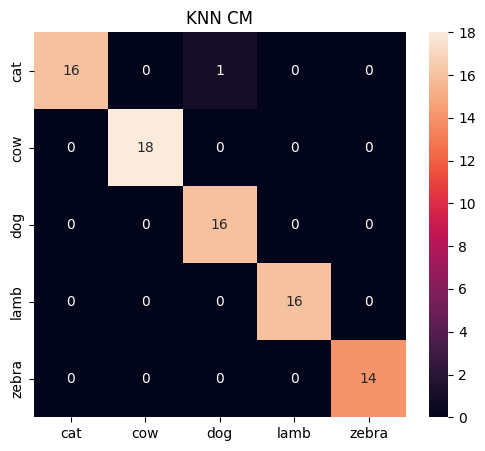

In [33]:
# Cell 12: Tune & train KNN
print("Tuning KNN...")
knn = KNeighborsClassifier()
knn_params = {"n_neighbors":[1,3,5,7,9],"weights":["uniform","distance"], "p":[1,2]}
gs_knn = GridSearchCV(knn, knn_params, cv=kf, n_jobs=-1, scoring="accuracy")
gs_knn.fit(X_train_red, y_train_red)
best_knn = gs_knn.best_estimator_
print("Best KNN params:", gs_knn.best_params_, "CV:", gs_knn.best_score_)
joblib.dump(best_knn, os.path.join(MODELS_DIR, "knn_best.pkl"))

y_knn = best_knn.predict(X_test_red)
print("KNN Test acc:", accuracy_score(y_test_red, y_knn))
print(classification_report(y_test_red, y_knn, target_names=classes))
cm = confusion_matrix(y_test_red, y_knn)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes); plt.title("KNN CM"); plt.show()

Tuning SVM...
Best SVM params: {'C': 1, 'gamma': 'scale'} CV: 0.9650090090090091
SVM Test acc: 1.0
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



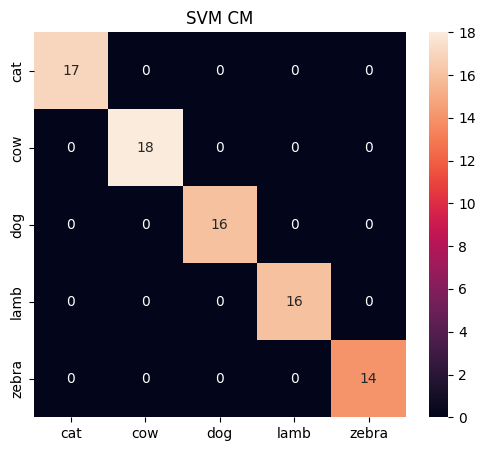

In [34]:
# Cell 13: Tune & train SVM
print("Tuning SVM...")
svm = SVC(kernel="rbf", probability=True)
svm_params = {"C":[0.1,1,10,50], "gamma":["scale","auto"]}
gs_svm = GridSearchCV(svm, svm_params, cv=kf, n_jobs=-1, scoring="accuracy")
gs_svm.fit(X_train_red, y_train_red)
best_svm = gs_svm.best_estimator_
print("Best SVM params:", gs_svm.best_params_, "CV:", gs_svm.best_score_)
joblib.dump(best_svm, os.path.join(MODELS_DIR, "svm_best.pkl"))

y_svm = best_svm.predict(X_test_red)
print("SVM Test acc:", accuracy_score(y_test_red, y_svm))
print(classification_report(y_test_red, y_svm, target_names=classes))
cm = confusion_matrix(y_test_red, y_svm)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes); plt.title("SVM CM"); plt.show()

Tuning RandomForest...
Best RF params: {'max_depth': 10, 'n_estimators': 300} CV: 0.9784864864864865
RF Test acc: 1.0
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



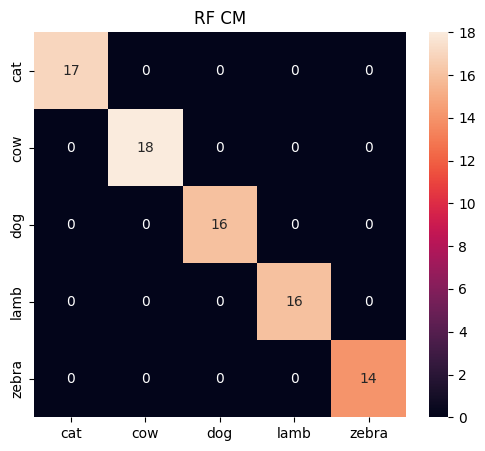

In [35]:
# Cell 14: Tune & train Random Forest
print("Tuning RandomForest...")
rf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_params = {"n_estimators":[100,300], "max_depth":[None,10,30]}
gs_rf = GridSearchCV(rf, rf_params, cv=kf, n_jobs=-1, scoring="accuracy")
gs_rf.fit(X_train_red, y_train_red)
best_rf = gs_rf.best_estimator_
print("Best RF params:", gs_rf.best_params_, "CV:", gs_rf.best_score_)
joblib.dump(best_rf, os.path.join(MODELS_DIR, "rf_best.pkl"))

y_rf = best_rf.predict(X_test_red)
print("RF Test acc:", accuracy_score(y_test_red, y_rf))
print(classification_report(y_test_red, y_rf, target_names=classes))
cm = confusion_matrix(y_test_red, y_rf)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes); plt.title("RF CM"); plt.show()

Voting Test Accuracy: 1.0
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



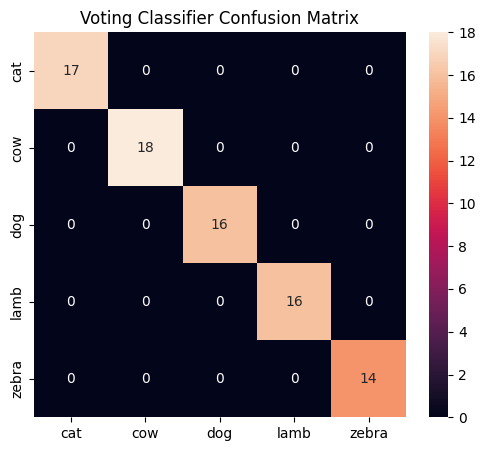

Stacking Test Accuracy: 1.0
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



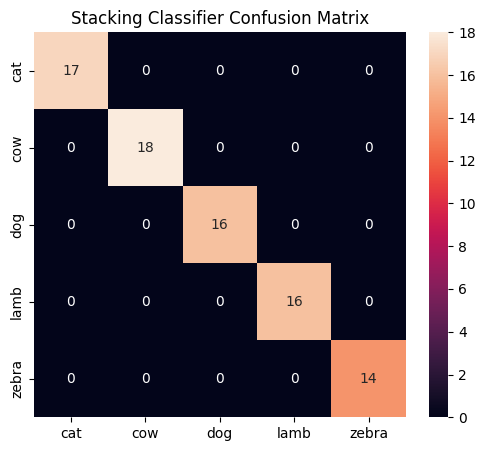

All models saved to: models


In [36]:
# Cell 15: Build Voting and Stacking Ensembles (soft voting + stacking)

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Define directory to save models
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# Build Voting Classifier with soft voting (uses predicted probabilities)
voting = VotingClassifier(
    estimators=[
        ("knn", best_knn),  # Your tuned KNN model
        ("svm", best_svm),  # Your tuned SVM model
        ("rf", best_rf)     # Your tuned Random Forest model
    ],
    voting="soft",
    n_jobs=-1
)

# Train Voting ensemble
voting.fit(X_train_red, y_train_red)

# Save Voting model
joblib.dump(voting, os.path.join(MODELS_DIR, "voting.pkl"))

# Predict on test set using Voting ensemble
y_v = voting.predict(X_test_red)

# Evaluate Voting ensemble
print("Voting Test Accuracy:", accuracy_score(y_test_red, y_v))
print(classification_report(y_test_red, y_v, target_names=classes))

# Plot confusion matrix for Voting ensemble
cm = confusion_matrix(y_test_red, y_v)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Voting Classifier Confusion Matrix")
plt.show()

# Build Stacking Classifier with Logistic Regression as final estimator
stack = StackingClassifier(
    estimators=[
        ("knn", best_knn),
        ("svm", best_svm),
        ("rf", best_rf)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5,       # 5-fold cross-validation for meta-learner training
    n_jobs=-1
)

# Train Stacking ensemble
stack.fit(X_train_red, y_train_red)

# Save Stacking model
joblib.dump(stack, os.path.join(MODELS_DIR, "stacking.pkl"))

# Predict on test set using Stacking ensemble
y_stack = stack.predict(X_test_red)

# Evaluate Stacking ensemble
print("Stacking Test Accuracy:", accuracy_score(y_test_red, y_stack))
print(classification_report(y_test_red, y_stack, target_names=classes))

# Plot confusion matrix for Stacking ensemble
cm = confusion_matrix(y_test_red, y_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Stacking Classifier Confusion Matrix")
plt.show()

print(f"All models saved to: {MODELS_DIR}")

Model: KNN
Accuracy: 98.77% | Precision: 98.84% | Recall: 98.77% | F1: 98.77%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      0.94      0.97        17
         cow       1.00      1.00      1.00        18
         dog       0.94      1.00      0.97        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



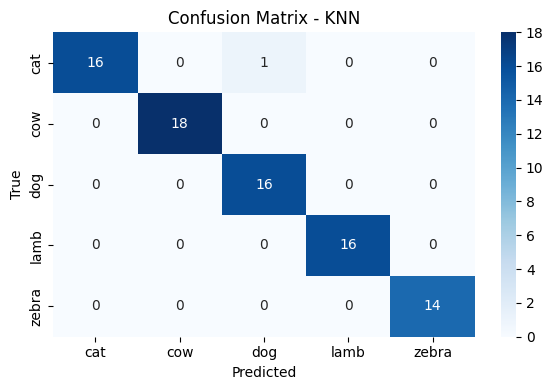

Model: SVM
Accuracy: 100.00% | Precision: 100.00% | Recall: 100.00% | F1: 100.00%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



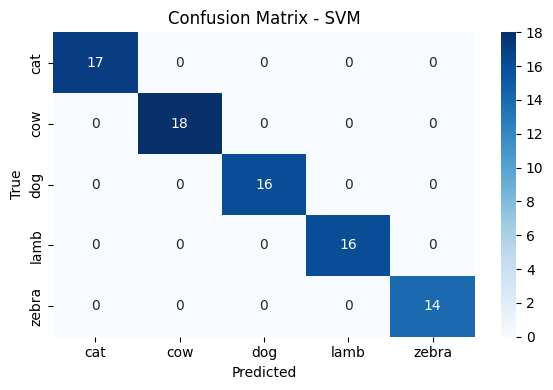

Model: RandomForest
Accuracy: 100.00% | Precision: 100.00% | Recall: 100.00% | F1: 100.00%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



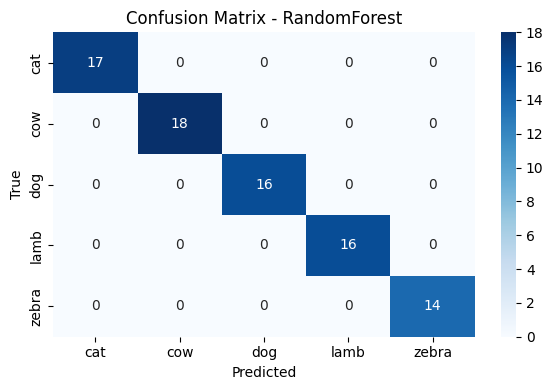

Model: Voting
Accuracy: 100.00% | Precision: 100.00% | Recall: 100.00% | F1: 100.00%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



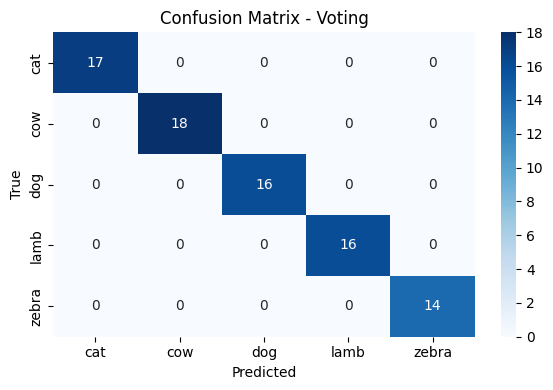

Model: Stacking
Accuracy: 100.00% | Precision: 100.00% | Recall: 100.00% | F1: 100.00%

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        17
         cow       1.00      1.00      1.00        18
         dog       1.00      1.00      1.00        16
        lamb       1.00      1.00      1.00        16
       zebra       1.00      1.00      1.00        14

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



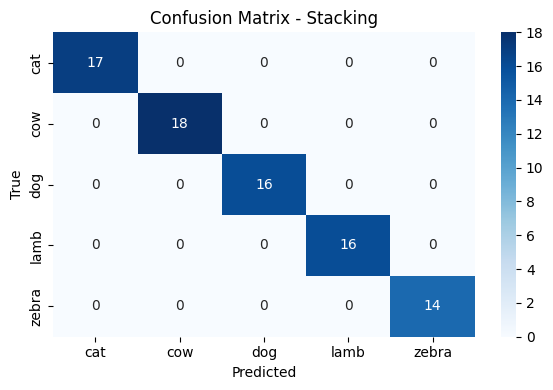


=== Summary Table ===


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
0,KNN,98.765432,98.838054,98.765432,98.765432
1,SVM,100.000000,100.000000,100.000000,100.000000
2,RandomForest,100.000000,100.000000,100.000000,100.000000
3,Voting,100.000000,100.000000,100.000000,100.000000
4,Stacking,100.000000,100.000000,100.000000,100.000000


In [37]:
# Cell 16: Final evaluation summary & confusion matrices (percentage format)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# ✅ Explicitly set your class names
classes = ['cat', 'cow', 'dog', 'lamb', 'zebra']

# Create results directory for saved plots
os.makedirs("results", exist_ok=True)

def plot_conf_matrix(y_true, y_pred, title):
    """Plot and save confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f"results/confusion_matrix_{title}.png")
    plt.show()

def show_summary():
    models_preds = {
        "KNN": y_knn,
        "SVM": y_svm,
        "RandomForest": y_rf,
        "Voting": y_v,
        "Stacking": y_stack
    }
    
    summary_data = []
    
    for name, preds in models_preds.items():
        acc = accuracy_score(y_test_red, preds) * 100
        prec = precision_score(y_test_red, preds, average='weighted', zero_division=0) * 100
        rec = recall_score(y_test_red, preds, average='weighted', zero_division=0) * 100
        f1 = f1_score(y_test_red, preds, average='weighted', zero_division=0) * 100
        
        summary_data.append([name, acc, prec, rec, f1])
        
        print("="*60)
        print(f"Model: {name}")
        print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1: {f1:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_test_red, preds, target_names=classes, zero_division=0, digits=2))
        
        plot_conf_matrix(y_test_red, preds, name)
    
    # Summary DataFrame
    df_summary = pd.DataFrame(summary_data, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"])
    print("\n=== Summary Table ===")
    display(df_summary)

# Run final evaluation
show_summary()

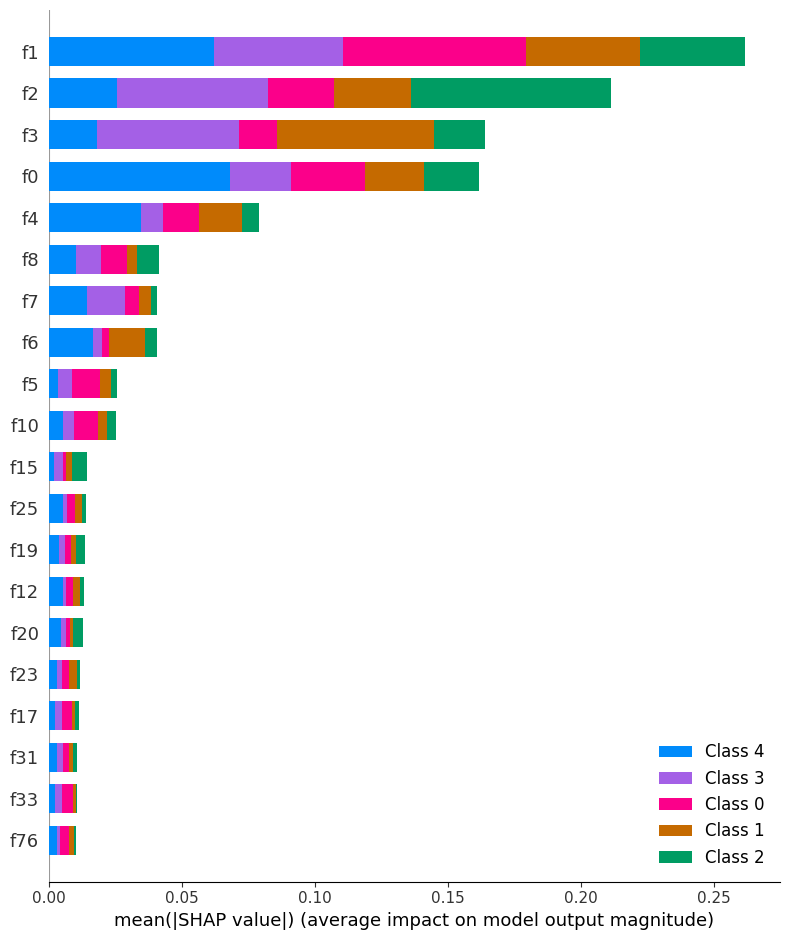

In [38]:
# Cell 17: Explainability (SHAP) for RandomForest (tree explainer)
try:
    explainer = shap.TreeExplainer(best_rf)
    idx = min(100, len(X_test_red))
    shap_values = explainer.shap_values(X_test_red[:idx])
    # Summary plot (class 0 summary, adjust if needed)
    shap.summary_plot(shap_values, X_test_red[:idx], feature_names=[f"f{i}" for i in range(X_test_red.shape[1])], show=True)
except Exception as e:
    print("SHAP explainability failed or too slow in this environment:", e)


In [39]:
# Cell 18: Active Learning
from sklearn.svm import SVC
np.random.seed(RANDOM_SEED)

POOL_SIZE = max(100, int(0.2 * len(X_train_red)))
if POOL_SIZE >= len(X_train_red):
    print("Dataset too small for active learning demo. Skipping.")
else:
    pool_X = X_train_red[-POOL_SIZE:].copy()
    pool_y = y_train_red[-POOL_SIZE:].copy()
    labeled_X = X_train_red[:-POOL_SIZE].copy()
    labeled_y = y_train_red[:-POOL_SIZE].copy()

    model_al = SVC(probability=True, kernel="rbf", random_state=RANDOM_SEED)
    for it in range(5):  # 5 query iterations
        model_al.fit(labeled_X, labeled_y)
        probs = model_al.predict_proba(pool_X)
        uncertainty = 1 - probs.max(axis=1)  # highest uncertainty
        q = uncertainty.argmax()
        # add queried sample to labeled set
        labeled_X = np.vstack([labeled_X, pool_X[q:q+1]])
        labeled_y = np.append(labeled_y, pool_y[q])
        pool_X = np.delete(pool_X, q, axis=0)
        pool_y = np.delete(pool_y, q, axis=0)
        print(f"AL iter {it+1}: added sample with uncertainty {uncertainty[q]:.4f}")
    print("Active learning demo finished.")


AL iter 1: added sample with uncertainty 0.4949
AL iter 2: added sample with uncertainty 0.3858
AL iter 3: added sample with uncertainty 0.3784
AL iter 4: added sample with uncertainty 0.2368
AL iter 5: added sample with uncertainty 0.2308
Active learning demo finished.


In [40]:
# Cell 19: Simple AutoML example (grid search over top models)
from sklearn.model_selection import GridSearchCV
candidates = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors":[3,5,7], "weights":["distance","uniform"]}),
    "SVM": (SVC(probability=True), {"C":[0.1,1,10], "gamma":["scale"]}),
    "RF": (RandomForestClassifier(random_state=RANDOM_SEED), {"n_estimators":[100,300], "max_depth":[None,10]})
}
best_candidates = {}
for name, (est, params) in candidates.items():
    print("Grid searching:", name)
    gs = GridSearchCV(est, params, cv=3, n_jobs=-1, scoring="accuracy")
    gs.fit(X_train_red, y_train_red)
    best_candidates[name] = (gs.best_score_, gs.best_params_, gs.best_estimator_)
    print(f"{name} best CV: {gs.best_score_:.4f}, params: {gs.best_params_}")

# report best among candidates
best_name = max(best_candidates.items(), key=lambda kv: kv[1][0])[0]
print("AutoML pick (best CV):", best_name, best_candidates[best_name])

Grid searching: KNN
KNN best CV: 0.9274, params: {'n_neighbors': 3, 'weights': 'uniform'}
Grid searching: SVM
SVM best CV: 0.9704, params: {'C': 10, 'gamma': 'scale'}
Grid searching: RF
RF best CV: 0.9758, params: {'max_depth': None, 'n_estimators': 300}
AutoML pick (best CV): RF (0.9758064516129034, {'max_depth': None, 'n_estimators': 300}, RandomForestClassifier(n_estimators=300, random_state=42))


In [41]:
# Cell 20: Checking
print("classes:", 'classes' in globals())
print("MODELS_DIR:", 'MODELS_DIR' in globals())
print("joblib imported:", 'joblib' in globals())
print("MODELS_DIR exists:", os.path.isdir(MODELS_DIR) if 'MODELS_DIR' in globals() else False)

classes: True
MODELS_DIR: True
joblib imported: True
MODELS_DIR exists: True


In [42]:
# Cell 21: Save final artifacts
joblib.dump({"classes": classes}, os.path.join(MODELS_DIR, "meta.pkl"))
print("Saved meta and all trained models to", MODELS_DIR)

Saved meta and all trained models to models
